# Backtesting

Backtesting assesses the viability of a trading strategy by discovering how it would play out using historical data.
Backtesting is a key component of effective trading system development.

If backtesting works, traders and analysts may have the confidence to employ it going forward!

The following code backtests the Nifty50 Momemtum strategy developed previously, over 'X' number of days given by the user.


In [1]:
import yfinance as yf
import numpy as np #The Numpy numerical computing library
import pandas as pd #The Pandas data science library
import requests #The requests library for HTTP requests in Python
import xlsxwriter #The XlsxWriter libarary for 
import math #The Python math module
from scipy import stats #The SciPy stats module
from datetime import date
from statistics import mean

today = str(date.today())
year=today[:4]
month=int(today[5]+today[6])-2
day=today[8]+today[9]
if (month<10):
    month="0"+str(month)

if(month==1):
    year=int(year)-1
    month=11
if(month==0):
    year=int(year)-1
    month=12
    
two_months_ago= year+"-"+month+"-"+day

stocks= pd.read_csv('NIFTY_50_STOCKS.csv')


In [2]:
days=input("Enter number of days for backtesting: ")

Enter number of days for backtesting: 10


In [3]:
company_pl={} #creating a dictionary to store P/L of each stock individually over 'X' days
for stock in stocks['Symbol']:
    stock= stock +".NS"
    company_pl[stock]=0
company_pl

{'TATASTEEL.NS': 0,
 'BAJFINANCE.NS': 0,
 'M&M.NS': 0,
 'BRITANNIA.NS': 0,
 'IOC.NS': 0,
 'BPCL.NS': 0,
 'JSWSTEEL.NS': 0,
 'BAJAJFINSV.NS': 0,
 'RELIANCE.NS': 0,
 'HDFC.NS': 0,
 'HINDUNILVR.NS': 0,
 'NTPC.NS': 0,
 'NESTLEIND.NS': 0,
 'SUNPHARMA.NS': 0,
 'ADANIPORTS.NS': 0,
 'HCLTECH.NS': 0,
 'HDFCBANK.NS': 0,
 'DRREDDY.NS': 0,
 'HDFCLIFE.NS': 0,
 'TCS.NS': 0,
 'AXISBANK.NS': 0,
 'TITAN.NS': 0,
 'ITC.NS': 0,
 'HINDALCO.NS': 0,
 'SBILIFE.NS': 0,
 'WIPRO.NS': 0,
 'ICICIBANK.NS': 0,
 'ASIANPAINT.NS': 0,
 'INDUSINDBK.NS': 0,
 'GRASIM.NS': 0,
 'INFY.NS': 0,
 'KOTAKBANK.NS': 0,
 'TATACONSUM.NS': 0,
 'LT.NS': 0,
 'BHARTIARTL.NS': 0,
 'ONGC.NS': 0,
 'CIPLA.NS': 0,
 'UPL.NS': 0,
 'TECHM.NS': 0,
 'HEROMOTOCO.NS': 0,
 'DIVISLAB.NS': 0,
 'TATAMOTORS.NS': 0,
 'COALINDIA.NS': 0,
 'ULTRACEMCO.NS': 0,
 'SBIN.NS': 0,
 'BAJAJ-AUTO.NS': 0,
 'POWERGRID.NS': 0,
 'EICHERMOT.NS': 0,
 'SHREECEM.NS': 0,
 'MARUTI.NS': 0}

In [4]:
portfolio_size = input("Enter the value of your daily investment:")

Enter the value of your daily investment:1000000


In [5]:
hqm_columns = [
                'Ticker', 
                'Open Price',
                'Closed Price',
                'Number of Shares to Buy', 
                '3-day Price Return', 
                '1-week Price Return',
                '1-Month Price Return',
                'HQM Score'
                ]
hqm_dataframe= pd.DataFrame(columns = hqm_columns)

# Backtesting algorithm over 'X' days

After each iteration the P/L of each stock is added to the dictionary.

In [6]:
for i in range (0,int(days)):
    for stock in stocks['Symbol']:
        stock=stock+".NS"
        df = yf.download(stock, 
                         start=two_months_ago, 
                         end=today, 
                         progress=False,)
        df['Open_1'] = df['Open'].shift(3)
        df['Three_day_change(%)'] = ((df['Open'] - df['Open_1'])/df['Open_1'])*100
        df= df.drop('Open_1', axis=1)
        df['Open_1'] = df['Open'].shift(7)
        df['1week_change(%)'] = ((df['Open'] - df['Open_1'])/df['Open_1'])*100
        df= df.drop('Open_1', axis=1)
        df['Open_1'] = df['Open'].shift(22)
        df['1month_change(%)'] = ((df['Open'] - df['Open_1'])/df['Open_1'])*100
        df= df.drop('Open_1', axis=1)
        df = df.iloc[::-1]

        hqm_dataframe = hqm_dataframe.append(
                                             pd.Series([stock, 
                                             df['Open'][i],
                                             df['Close'][i],
                                             'N/A',
                                             df['Three_day_change(%)'][i],
                                             df['1week_change(%)'][i],
                                             df['1month_change(%)'][i],
                                             'N/A'
                                             ], index = hqm_columns), ignore_index = True)
        
        
        


    for row in hqm_dataframe.index:
        momentum_percentiles = []
        momentum_percentiles.append(hqm_dataframe.loc[row, '3-day Price Return'])
        momentum_percentiles.append(hqm_dataframe.loc[row, '1-week Price Return'])
        momentum_percentiles.append(hqm_dataframe.loc[row, '1-Month Price Return'])
        hqm_dataframe.loc[row, 'HQM Score'] = mean(momentum_percentiles)
    hqm_dataframe=hqm_dataframe.sort_values(by = 'HQM Score', ascending = False)
    hqm_dataframe.reset_index(inplace = True)
    hqm_dataframe.drop('index', axis=1, inplace = True)
    hqm_dataframe=hqm_dataframe[:10]
    position_size = float(portfolio_size) / len(hqm_dataframe['Ticker'])
    for i in range(0, len(hqm_dataframe['Ticker'])):
        hqm_dataframe.loc[i, 'Number of Shares to Buy'] = math.floor(position_size / hqm_dataframe['Open Price'][i])
    hqm_dataframe['P/L']=  (hqm_dataframe['Closed Price']- hqm_dataframe['Open Price'])* hqm_dataframe['Number of Shares to Buy']
    
    Ptr=0
    while(1):
        if(Ptr==10):
            break;
        company=hqm_dataframe['Ticker'][Ptr]
        company_pl[company]+=hqm_dataframe['P/L'][Ptr]
        Ptr+=1

        
      
    
    hqm_dataframe= pd.DataFrame(columns = hqm_columns)
    
        
        
        
        
        

        
        
        

        

# Viewing the performance of the strategy

In [7]:
company_pl

{'TATASTEEL.NS': -5640.014892578125,
 'BAJFINANCE.NS': 2837.24853515625,
 'M&M.NS': 0,
 'BRITANNIA.NS': 29.696044921875,
 'IOC.NS': 0,
 'BPCL.NS': 0,
 'JSWSTEEL.NS': -3766.79833984375,
 'BAJAJFINSV.NS': 4713.759765625,
 'RELIANCE.NS': 0,
 'HDFC.NS': 27.740966796875,
 'HINDUNILVR.NS': 0,
 'NTPC.NS': 0,
 'NESTLEIND.NS': 0,
 'SUNPHARMA.NS': -2237.3545532226562,
 'ADANIPORTS.NS': 0,
 'HCLTECH.NS': 4371.8819580078125,
 'HDFCBANK.NS': 0,
 'DRREDDY.NS': 0,
 'HDFCLIFE.NS': 0,
 'TCS.NS': 3488.095947265625,
 'AXISBANK.NS': 0,
 'TITAN.NS': 532.2012939453125,
 'ITC.NS': 0,
 'HINDALCO.NS': -1340.7568664550781,
 'SBILIFE.NS': -1382.7584228515625,
 'WIPRO.NS': 1679.78955078125,
 'ICICIBANK.NS': -1790.7017211914062,
 'ASIANPAINT.NS': 0,
 'INDUSINDBK.NS': 0,
 'GRASIM.NS': 0,
 'INFY.NS': 4727.1943359375,
 'KOTAKBANK.NS': -2127.601318359375,
 'TATACONSUM.NS': 5425.0484619140625,
 'LT.NS': -2211.1014404296875,
 'BHARTIARTL.NS': 2505.9924926757812,
 'ONGC.NS': 0,
 'CIPLA.NS': 0,
 'UPL.NS': 0,
 'TECHM.NS': 

# Calculating P/L for the entire portfolio

In [9]:
sum=0
for i in company_pl:
    sum+=company_pl[i]
sum 
#if value is negative then it is a loss

20690.554397583008

# Representing P/L using a DataFrame

In [10]:
columnss=['Ticker','P/L']
v_dataframe=pd.DataFrame(columns=columnss)

for company in company_pl:
    v_dataframe = v_dataframe.append(pd.Series([company,company_pl[company]], index=columnss), ignore_index = True)

v_dataframe

,Ticker,P/L
0,TATASTEEL.NS,-5640.014893
1,BAJFINANCE.NS,2837.248535
2,M&M.NS,0.000000
3,BRITANNIA.NS,29.696045
4,IOC.NS,0.000000
5,BPCL.NS,0.000000
6,JSWSTEEL.NS,-3766.798340
7,BAJAJFINSV.NS,4713.759766
8,RELIANCE.NS,0.000000
9,HDFC.NS,27.740967


# Representing P/L using a BarGraph

<ipython-input-15-e2597c16965b>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 30)


[Text(0, -7500.0, ''),
 Text(0, -5000.0, ''),
 Text(0, -2500.0, ''),
 Text(0, 0.0, ''),
 Text(0, 2500.0, ''),
 Text(0, 5000.0, ''),
 Text(0, 7500.0, ''),
 Text(0, 10000.0, ''),
 Text(0, 12500.0, ''),
 Text(0, 15000.0, '')]

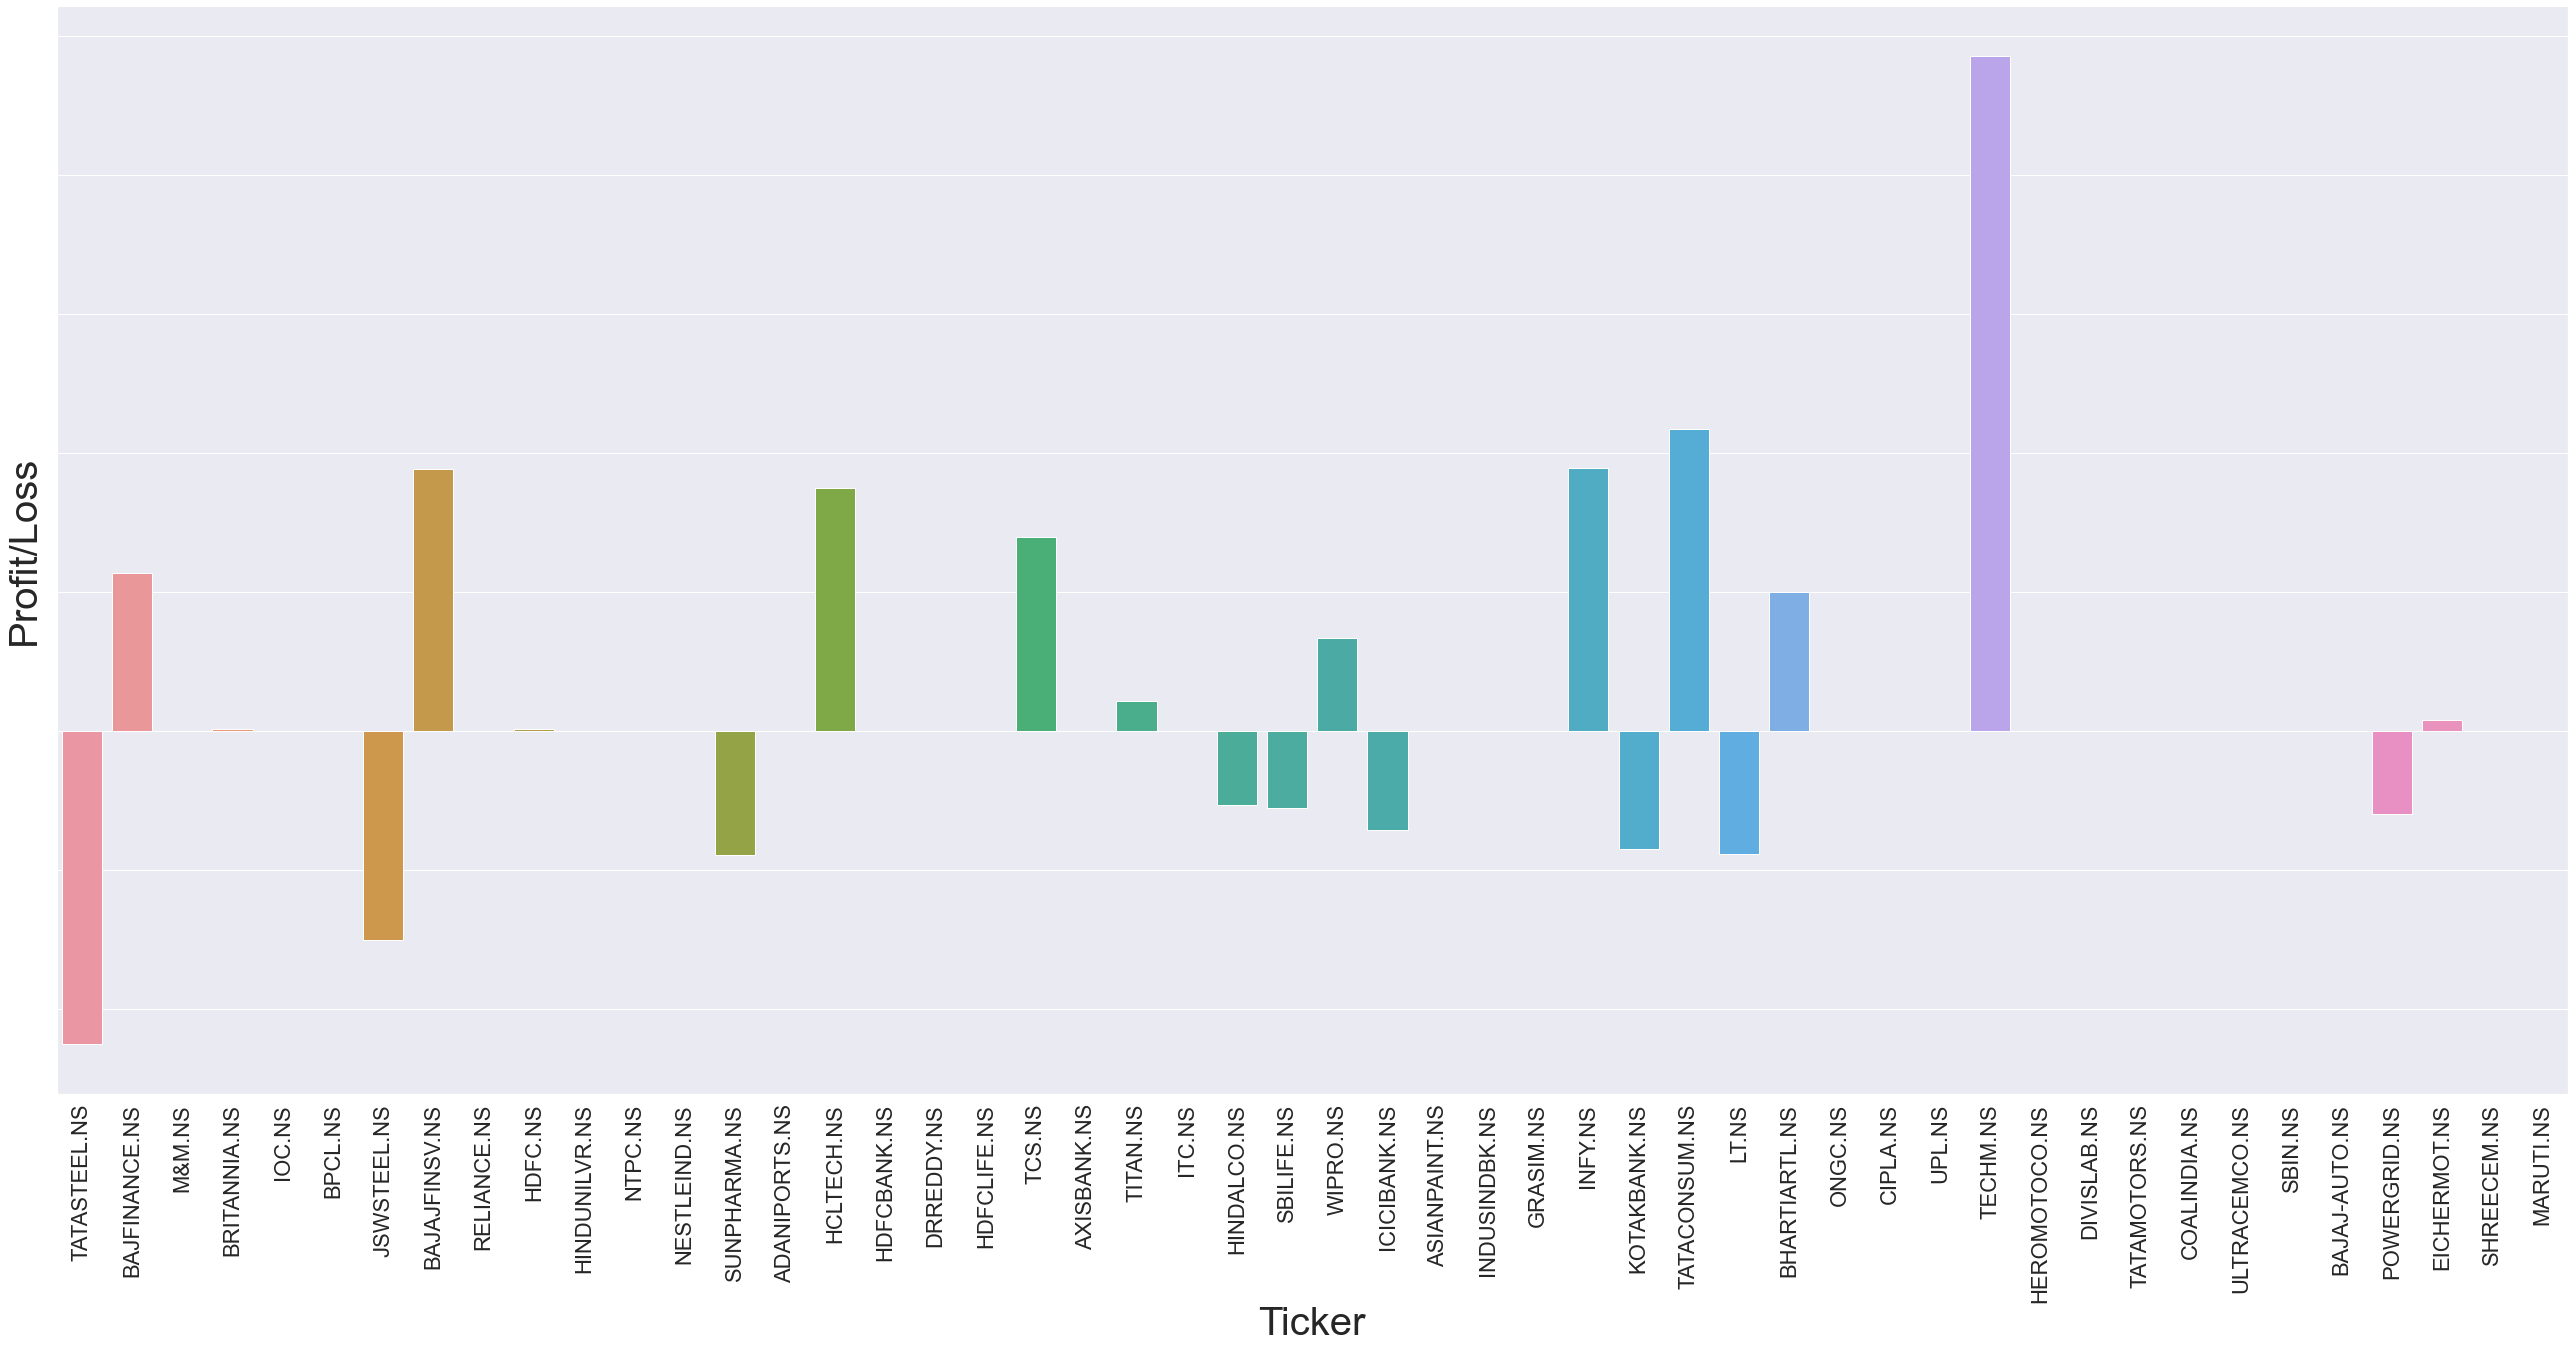

In [15]:
import seaborn as sns


sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(45,20)})
ax = sns.barplot(x="Ticker", y="P/L", data=v_dataframe)
ax.set_ylabel('Profit/Loss',fontsize=40);
ax.set_xlabel('Ticker',fontsize=40);
ax.set_xticklabels(ax.get_xmajorticklabels(), rotation=90,  fontsize = 22)
labels=[-1500,-1000,-500,0,500,1000,1500,2000,2500,3000]

ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 30)
